In [10]:
from plot_utils import plot_loss, plot_histogram_balance_of_dataset, plot_confusion_matrix, plot_multiclass_roc_auc, \
    plot_metrics_table
from model import Model
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from plot_utils import plot_multiclass_calibration_curve

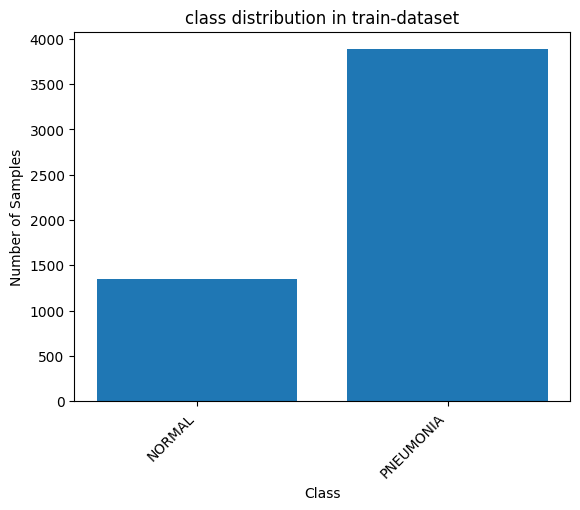

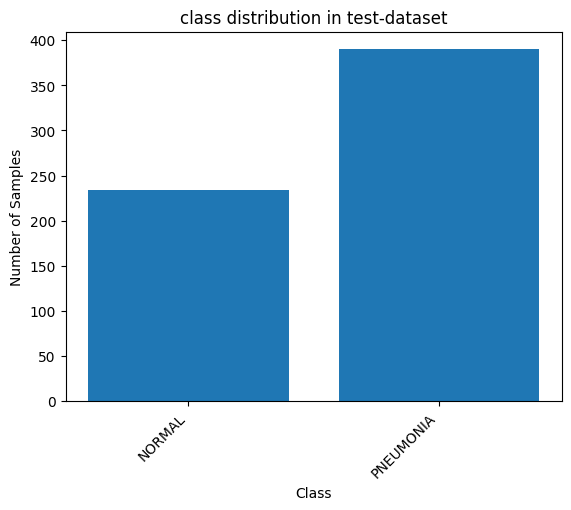

In [11]:
train_val_split_ratio = 0.8
batch_size = 32
learning_rate = 1e-4
patience_early_stopping = 15
patience_reduce_learning_rate = 4
weight_decay = 1e-4 #TODO
momentum = 0.9
epochs = 300
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"

model = Model(learning_rate=learning_rate, batch_size=batch_size, patience_early_stopping=patience_early_stopping,
              patience_reduce_learning_rate=patience_reduce_learning_rate, train_dir=train_dir,
              weight_decay=weight_decay, momentum=momentum, test_dir=test_dir,
              train_val_split_ratio=train_val_split_ratio)

plot_histogram_balance_of_dataset(train_dir, "class distribution in train-dataset")
plot_histogram_balance_of_dataset(test_dir, "class distribution in test-dataset")

Epoch 1/300, Train Loss: 0.3234, Validation Loss: 0.1902, Learning Rate: 0.0001


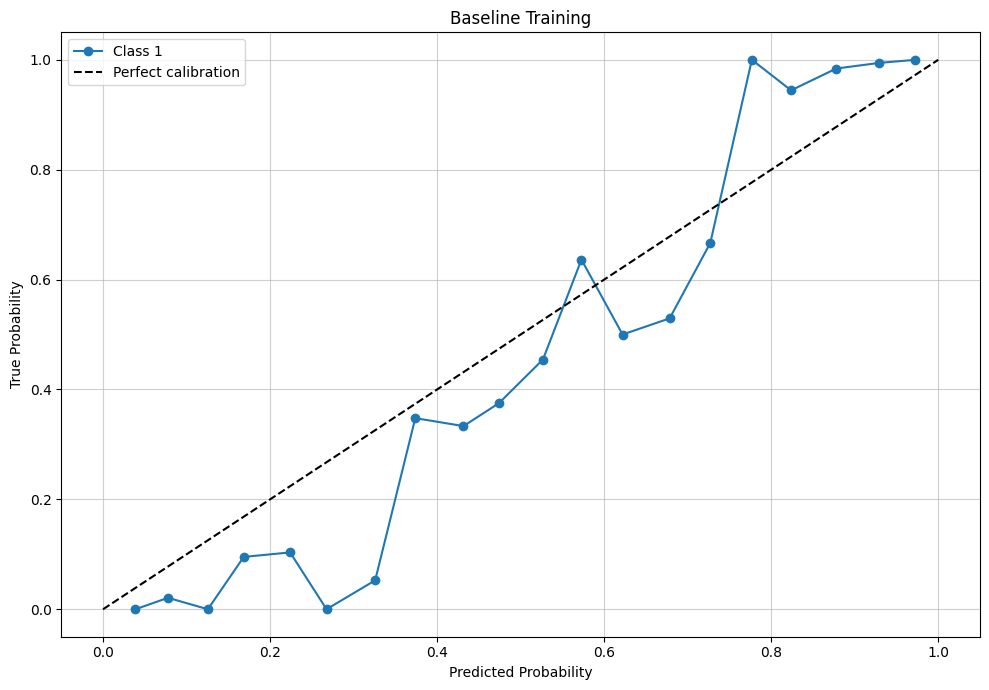

Epoch 2/300, Train Loss: 0.1634, Validation Loss: 0.1394, Learning Rate: 0.0001
Epoch 3/300, Train Loss: 0.1296, Validation Loss: 0.1183, Learning Rate: 0.0001
Epoch 4/300, Train Loss: 0.1079, Validation Loss: 0.1036, Learning Rate: 0.0001
Epoch 5/300, Train Loss: 0.0920, Validation Loss: 0.0907, Learning Rate: 0.0001
Epoch 6/300, Train Loss: 0.0804, Validation Loss: 0.0869, Learning Rate: 0.0001


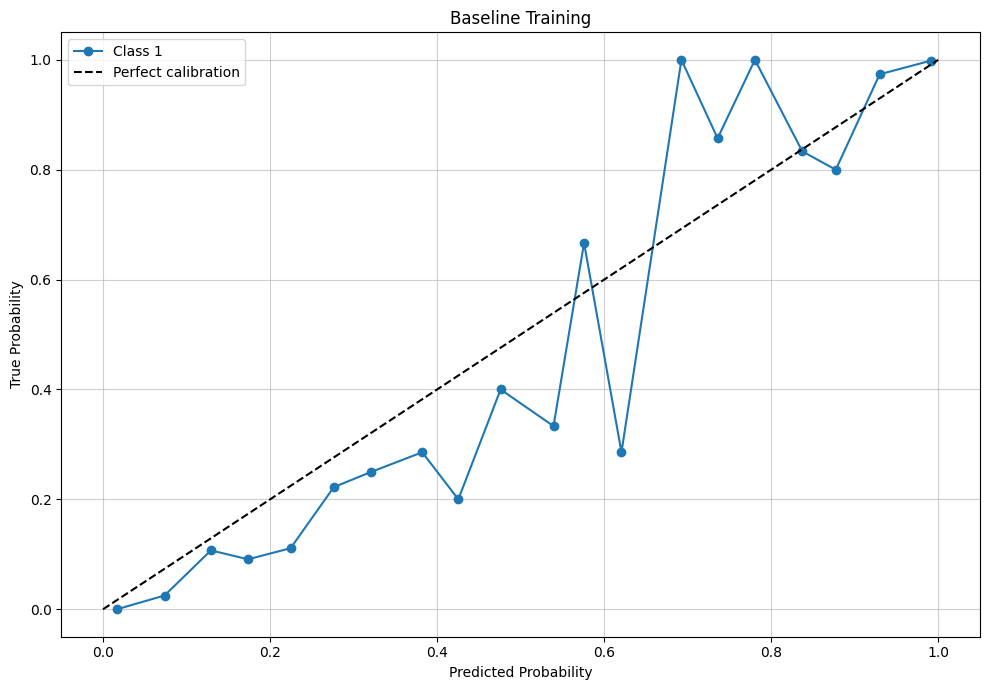

Epoch 7/300, Train Loss: 0.0681, Validation Loss: 0.0827, Learning Rate: 0.0001
Epoch 8/300, Train Loss: 0.0629, Validation Loss: 0.0772, Learning Rate: 0.0001
Epoch 9/300, Train Loss: 0.0571, Validation Loss: 0.0739, Learning Rate: 0.0001
Epoch 10/300, Train Loss: 0.0478, Validation Loss: 0.0723, Learning Rate: 0.0001
Epoch 11/300, Train Loss: 0.0491, Validation Loss: 0.0698, Learning Rate: 0.0001


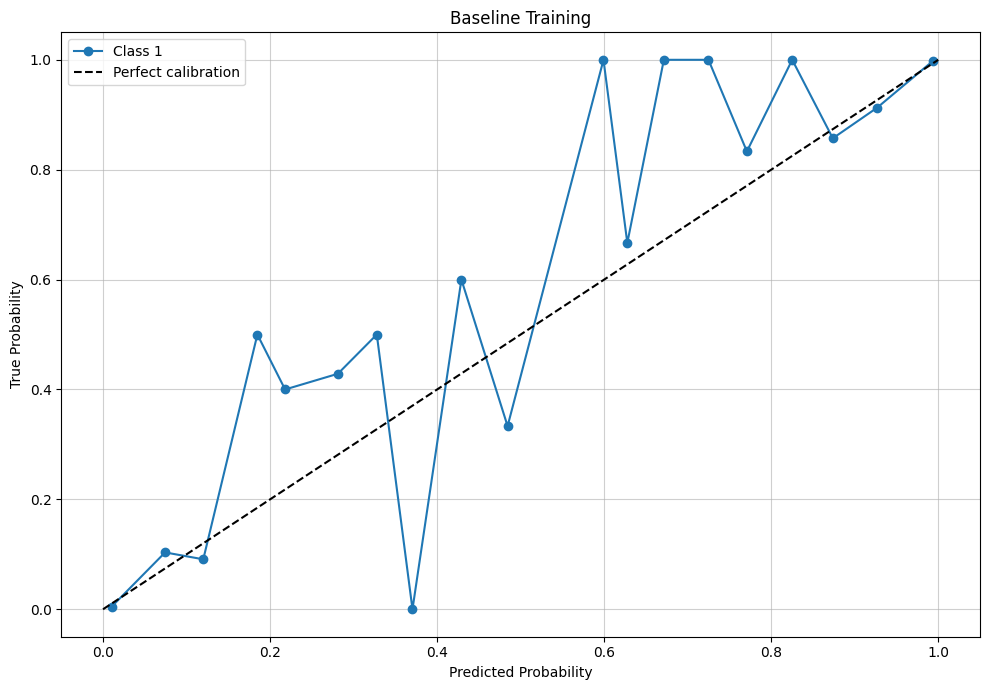

Epoch 12/300, Train Loss: 0.0400, Validation Loss: 0.0670, Learning Rate: 0.0001
Epoch 13/300, Train Loss: 0.0432, Validation Loss: 0.0655, Learning Rate: 0.0001
Epoch 14/300, Train Loss: 0.0348, Validation Loss: 0.0637, Learning Rate: 0.0001
Epoch 15/300, Train Loss: 0.0360, Validation Loss: 0.0648, Learning Rate: 0.0001
Epoch 16/300, Train Loss: 0.0272, Validation Loss: 0.0621, Learning Rate: 0.0001


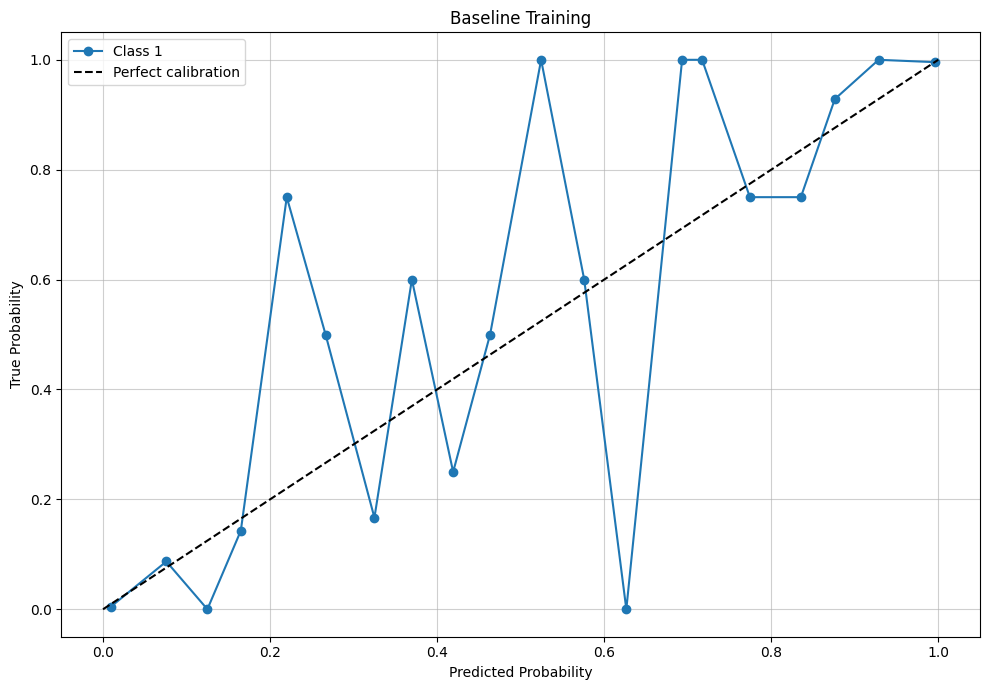

Epoch 17/300, Train Loss: 0.0269, Validation Loss: 0.0600, Learning Rate: 0.0001
Epoch 18/300, Train Loss: 0.0265, Validation Loss: 0.0633, Learning Rate: 0.0001
Epoch 19/300, Train Loss: 0.0225, Validation Loss: 0.0604, Learning Rate: 0.0001
Epoch 20/300, Train Loss: 0.0227, Validation Loss: 0.0588, Learning Rate: 0.0001
Epoch 21/300, Train Loss: 0.0196, Validation Loss: 0.0614, Learning Rate: 0.0001


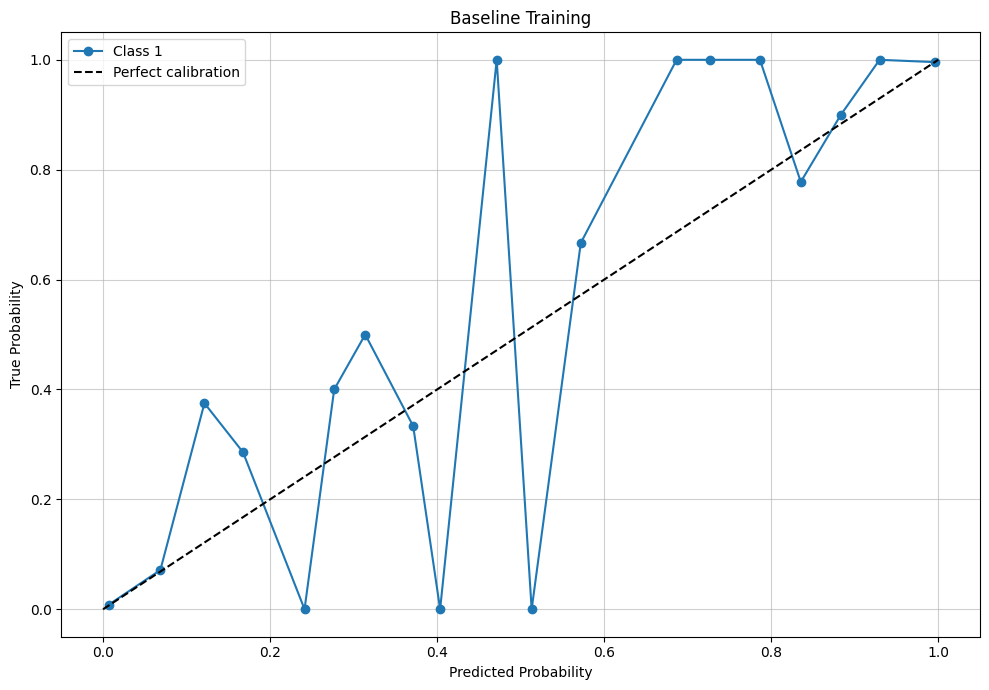

Epoch 22/300, Train Loss: 0.0236, Validation Loss: 0.0592, Learning Rate: 0.0001
Epoch 23/300, Train Loss: 0.0177, Validation Loss: 0.0581, Learning Rate: 0.0001
Epoch 24/300, Train Loss: 0.0182, Validation Loss: 0.0567, Learning Rate: 0.0001
Epoch 25/300, Train Loss: 0.0166, Validation Loss: 0.0579, Learning Rate: 0.0001
Epoch 26/300, Train Loss: 0.0154, Validation Loss: 0.0563, Learning Rate: 0.0001


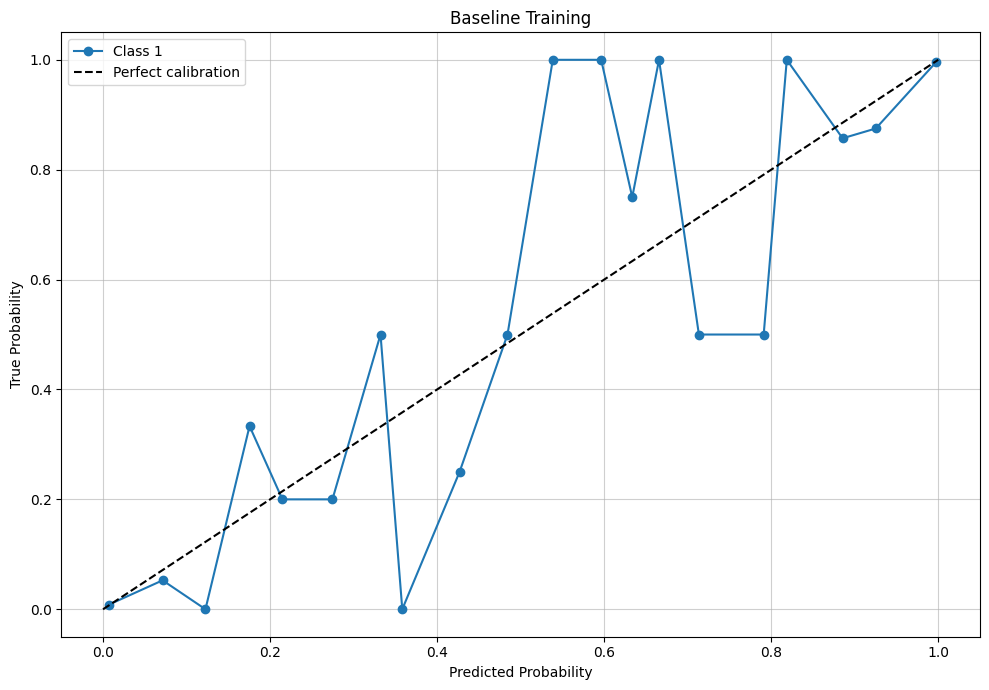

Epoch 27/300, Train Loss: 0.0144, Validation Loss: 0.0610, Learning Rate: 0.0001
Epoch 28/300, Train Loss: 0.0113, Validation Loss: 0.0567, Learning Rate: 0.0001
Epoch 29/300, Train Loss: 0.0106, Validation Loss: 0.0568, Learning Rate: 0.0001
Epoch 30/300, Train Loss: 0.0145, Validation Loss: 0.0582, Learning Rate: 0.0001
Epoch 31/300, Train Loss: 0.0158, Validation Loss: 0.0569, Learning Rate: 0.0001


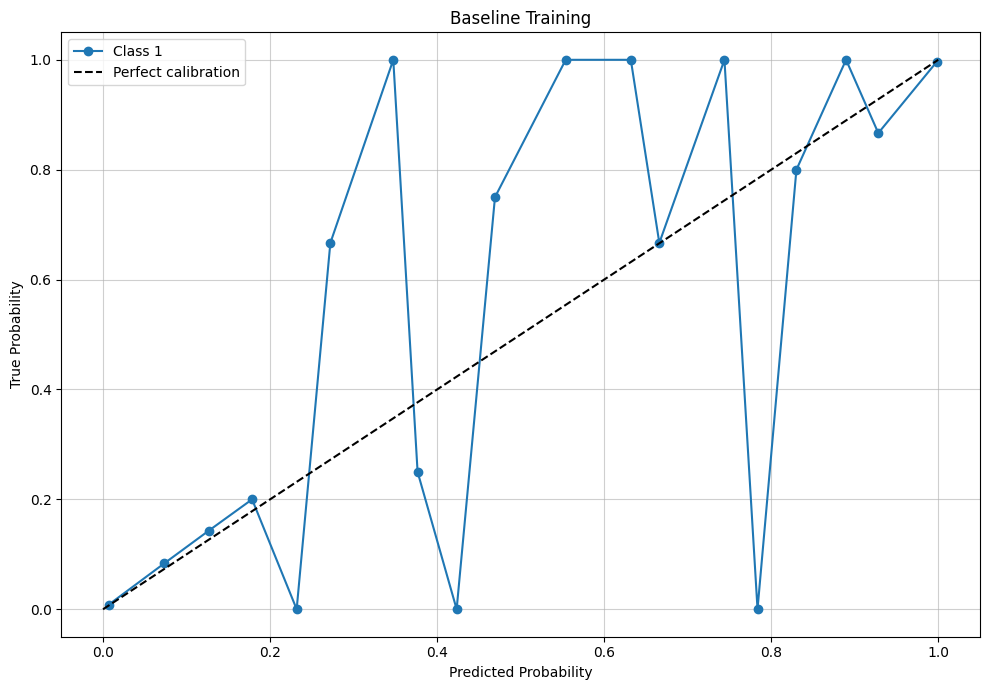

Epoch 32/300, Train Loss: 0.0109, Validation Loss: 0.0568, Learning Rate: 1e-05
Epoch 33/300, Train Loss: 0.0101, Validation Loss: 0.0566, Learning Rate: 1e-05
Epoch 34/300, Train Loss: 0.0112, Validation Loss: 0.0589, Learning Rate: 1e-05
Epoch 35/300, Train Loss: 0.0123, Validation Loss: 0.0563, Learning Rate: 1e-05
Epoch 36/300, Train Loss: 0.0119, Validation Loss: 0.0561, Learning Rate: 1e-05


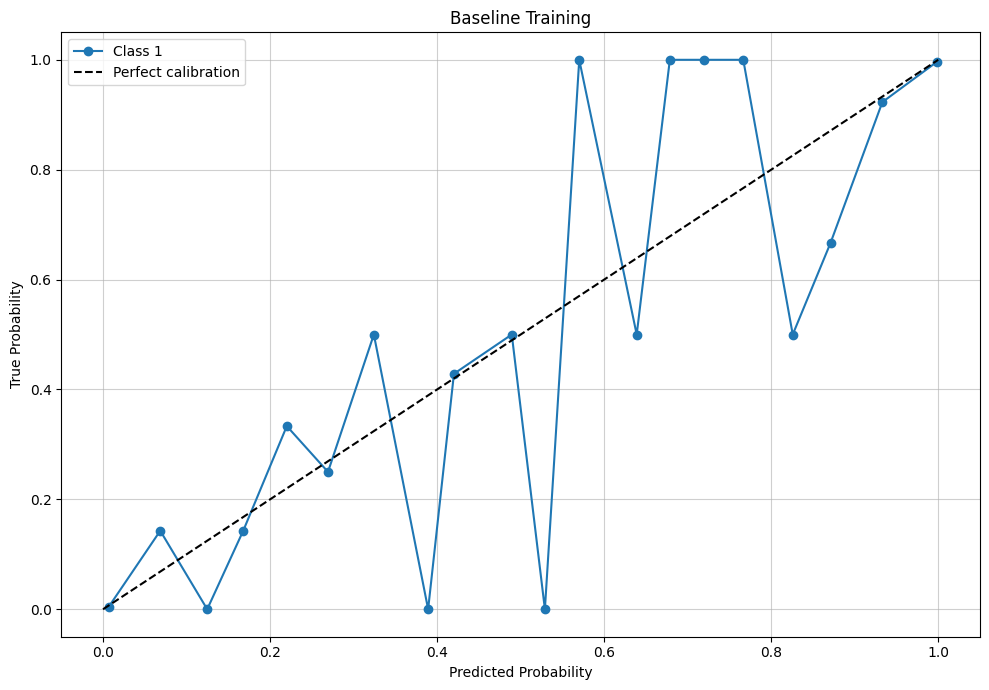

Epoch 37/300, Train Loss: 0.0123, Validation Loss: 0.0562, Learning Rate: 1e-05
Epoch 38/300, Train Loss: 0.0124, Validation Loss: 0.0567, Learning Rate: 1e-05
Epoch 39/300, Train Loss: 0.0107, Validation Loss: 0.0561, Learning Rate: 1e-05
Epoch 40/300, Train Loss: 0.0104, Validation Loss: 0.0562, Learning Rate: 1e-05
Epoch 41/300, Train Loss: 0.0123, Validation Loss: 0.0561, Learning Rate: 1e-05


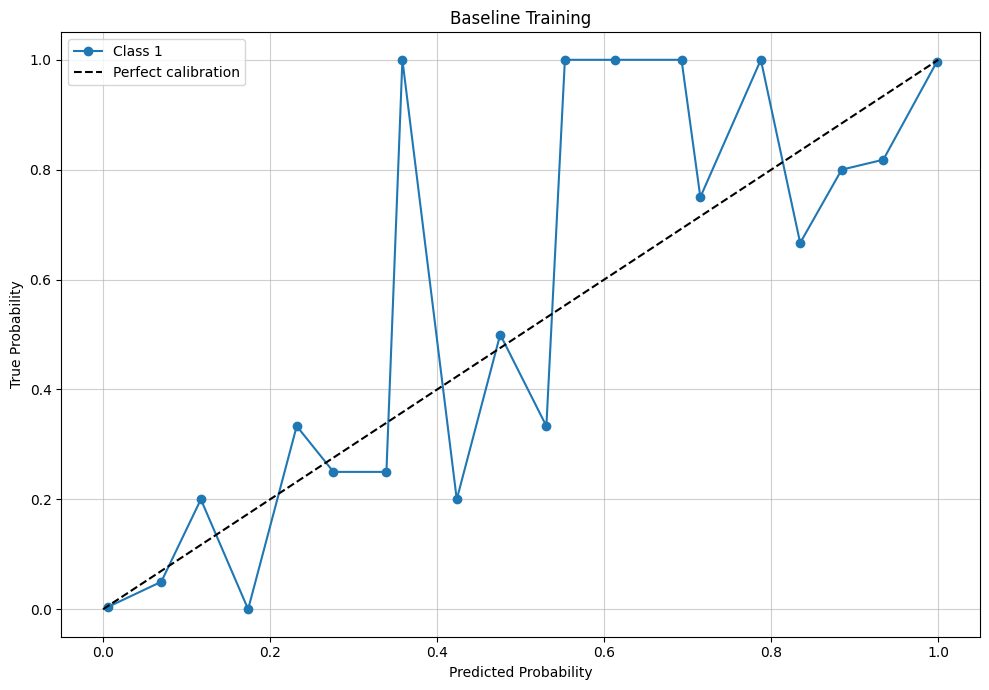

Epoch 42/300, Train Loss: 0.0129, Validation Loss: 0.0559, Learning Rate: 1.0000000000000002e-06
Epoch 43/300, Train Loss: 0.0090, Validation Loss: 0.0573, Learning Rate: 1.0000000000000002e-06
Epoch 44/300, Train Loss: 0.0106, Validation Loss: 0.0570, Learning Rate: 1.0000000000000002e-06
Epoch 45/300, Train Loss: 0.0100, Validation Loss: 0.0576, Learning Rate: 1.0000000000000002e-06
Epoch 46/300, Train Loss: 0.0090, Validation Loss: 0.0558, Learning Rate: 1.0000000000000002e-06


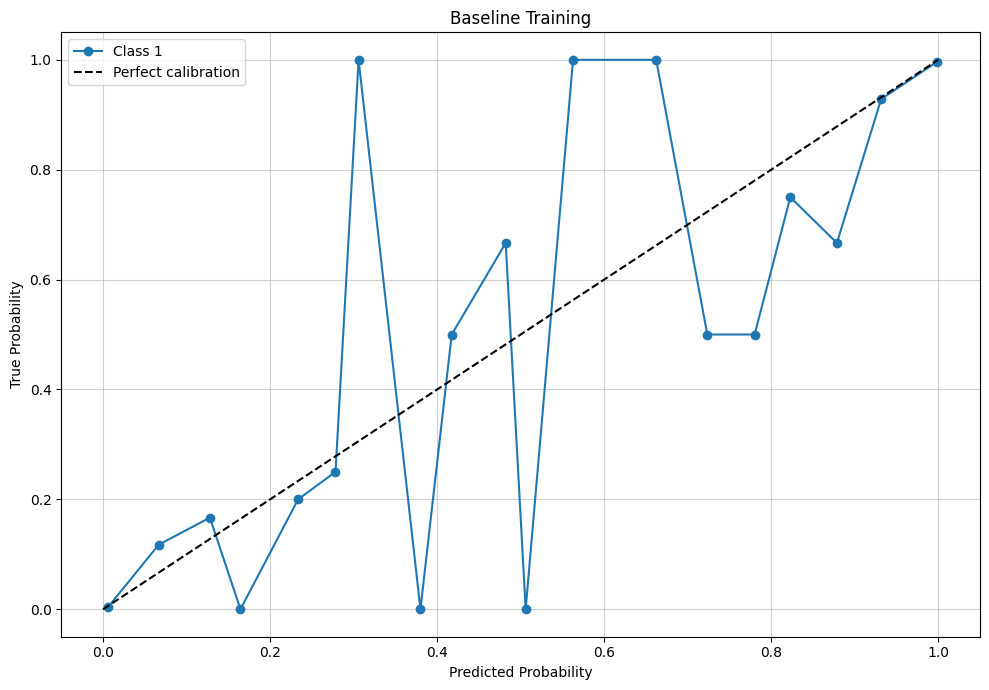

Epoch 47/300, Train Loss: 0.0113, Validation Loss: 0.0594, Learning Rate: 1.0000000000000002e-06
Epoch 48/300, Train Loss: 0.0121, Validation Loss: 0.0570, Learning Rate: 1.0000000000000002e-06
Epoch 49/300, Train Loss: 0.0117, Validation Loss: 0.0562, Learning Rate: 1.0000000000000002e-06
Epoch 50/300, Train Loss: 0.0093, Validation Loss: 0.0573, Learning Rate: 1.0000000000000002e-06
Epoch 51/300, Train Loss: 0.0099, Validation Loss: 0.0569, Learning Rate: 1.0000000000000002e-06


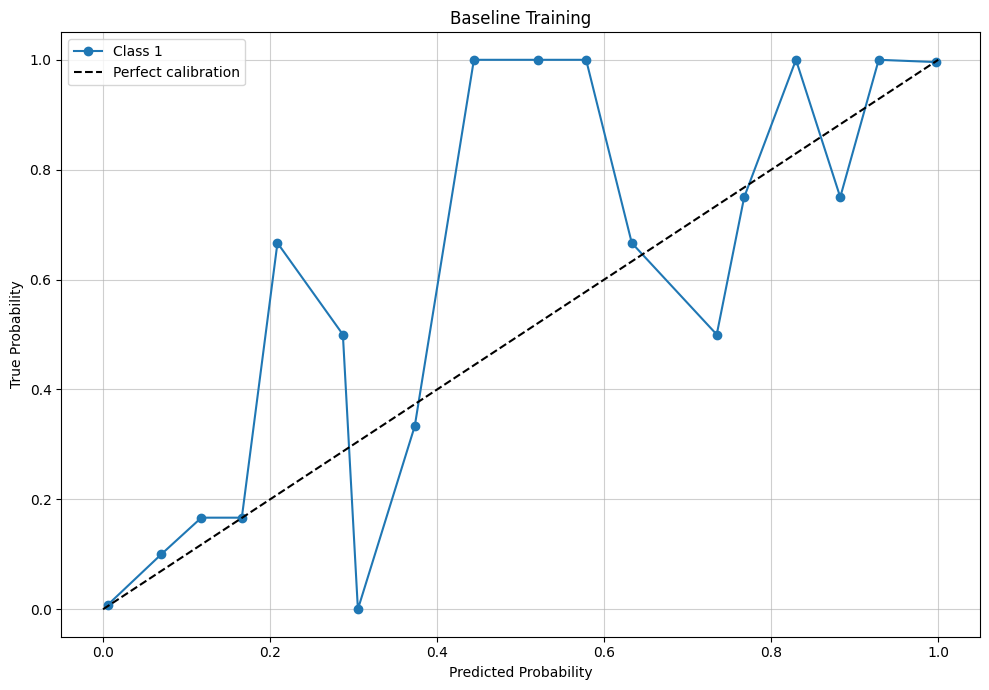

Epoch 52/300, Train Loss: 0.0122, Validation Loss: 0.0583, Learning Rate: 1.0000000000000002e-07
Epoch 53/300, Train Loss: 0.0127, Validation Loss: 0.0568, Learning Rate: 1.0000000000000002e-07
Epoch 54/300, Train Loss: 0.0105, Validation Loss: 0.0568, Learning Rate: 1.0000000000000002e-07
Epoch 55/300, Train Loss: 0.0098, Validation Loss: 0.0558, Learning Rate: 1.0000000000000002e-07
Epoch 56/300, Train Loss: 0.0120, Validation Loss: 0.0570, Learning Rate: 1.0000000000000002e-07


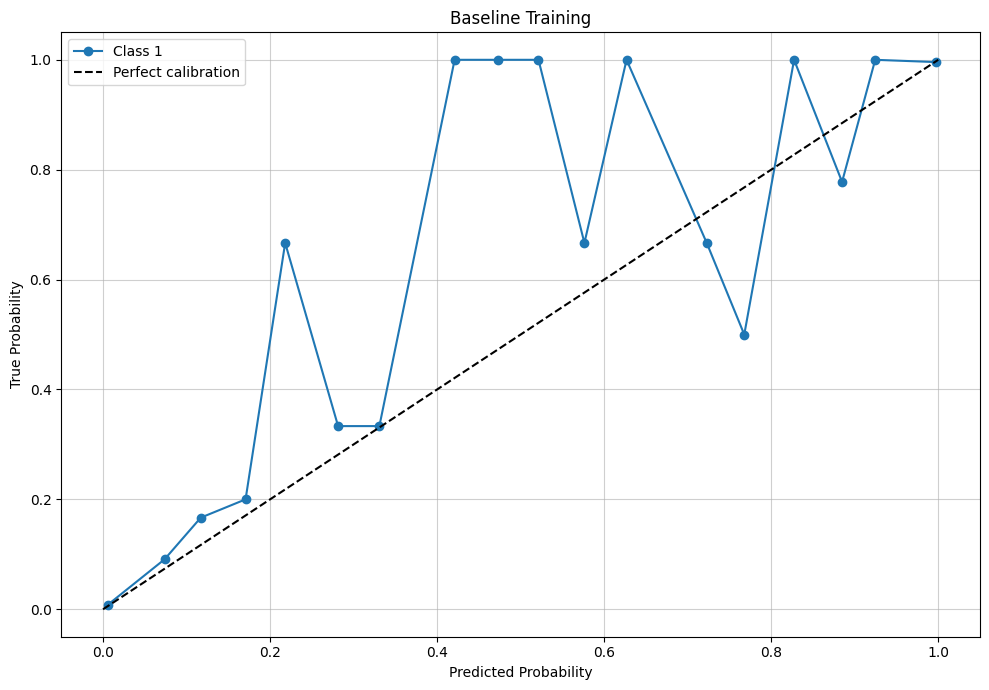

Epoch 57/300, Train Loss: 0.0133, Validation Loss: 0.0565, Learning Rate: 1.0000000000000002e-07
Epoch 58/300, Train Loss: 0.0114, Validation Loss: 0.0634, Learning Rate: 1.0000000000000002e-07
Epoch 59/300, Train Loss: 0.0098, Validation Loss: 0.0574, Learning Rate: 1.0000000000000002e-07
Epoch 60/300, Train Loss: 0.0087, Validation Loss: 0.0565, Learning Rate: 1.0000000000000002e-07
Epoch 61/300, Train Loss: 0.0117, Validation Loss: 0.0560, Learning Rate: 1.0000000000000004e-08


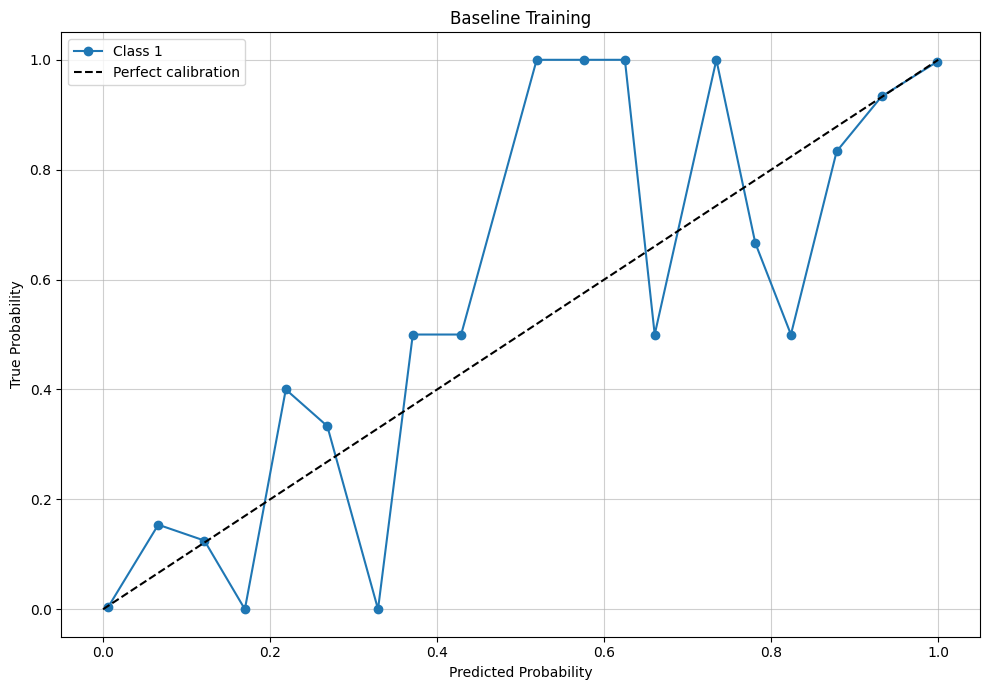

Epoch 62/300, Train Loss: 0.0142, Validation Loss: 0.0566, Learning Rate: 1.0000000000000004e-08
Epoch 63/300, Train Loss: 0.0099, Validation Loss: 0.0583, Learning Rate: 1.0000000000000004e-08
Epoch 64/300, Train Loss: 0.0100, Validation Loss: 0.0557, Learning Rate: 1.0000000000000004e-08
Epoch 65/300, Train Loss: 0.0102, Validation Loss: 0.0558, Learning Rate: 1.0000000000000004e-08
Epoch 66/300, Train Loss: 0.0132, Validation Loss: 0.0562, Learning Rate: 1.0000000000000004e-08


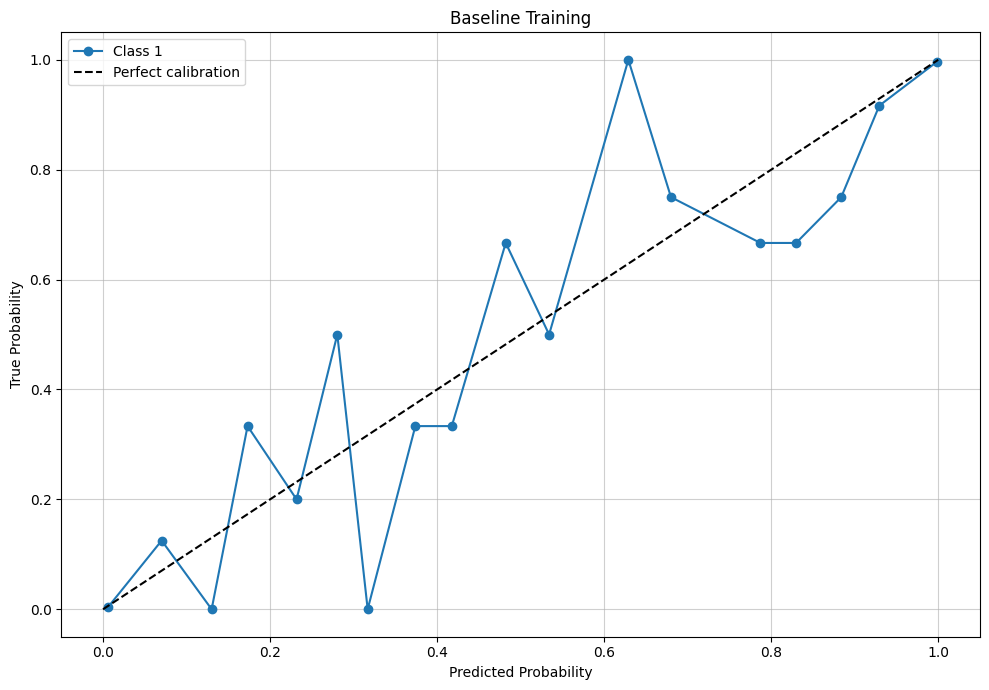

Epoch 67/300, Train Loss: 0.0094, Validation Loss: 0.0560, Learning Rate: 1.0000000000000004e-08
Epoch 68/300, Train Loss: 0.0110, Validation Loss: 0.0558, Learning Rate: 1.0000000000000004e-08
Epoch 69/300, Train Loss: 0.0113, Validation Loss: 0.0557, Learning Rate: 1.0000000000000004e-08
Epoch 70/300, Train Loss: 0.0126, Validation Loss: 0.0568, Learning Rate: 1.0000000000000004e-08
Epoch 71/300, Train Loss: 0.0111, Validation Loss: 0.0561, Learning Rate: 1.0000000000000004e-08


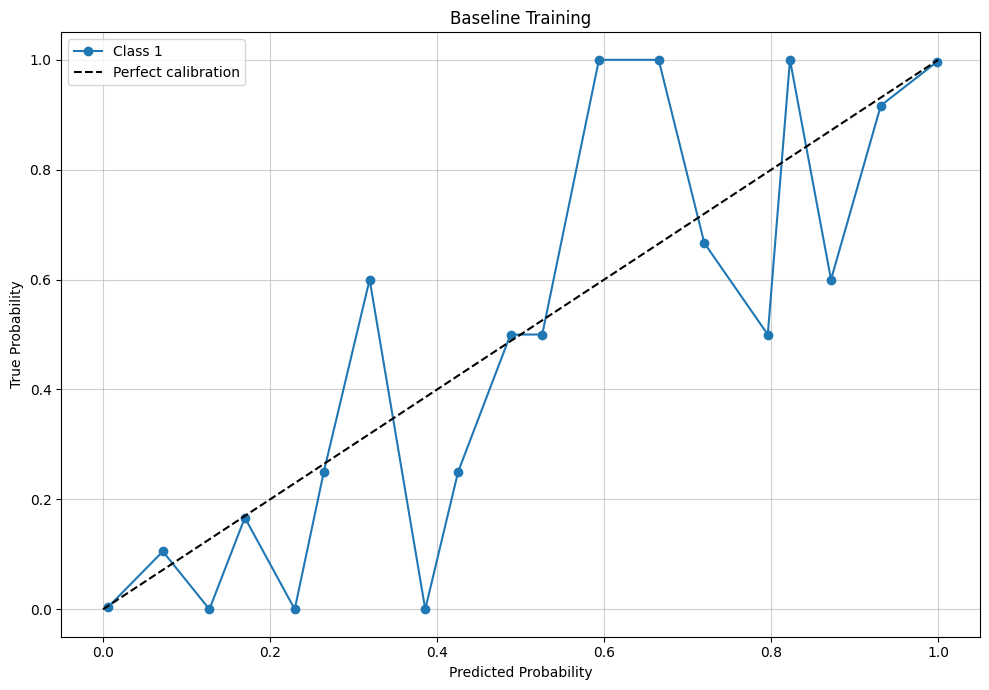

Epoch 72/300, Train Loss: 0.0104, Validation Loss: 0.0560, Learning Rate: 1.0000000000000004e-08
Epoch 73/300, Train Loss: 0.0137, Validation Loss: 0.0560, Learning Rate: 1.0000000000000004e-08
Epoch 74/300, Train Loss: 0.0110, Validation Loss: 0.0585, Learning Rate: 1.0000000000000004e-08
Epoch 75/300, Train Loss: 0.0131, Validation Loss: 0.0564, Learning Rate: 1.0000000000000004e-08
Epoch 76/300, Train Loss: 0.0102, Validation Loss: 0.0563, Learning Rate: 1.0000000000000004e-08


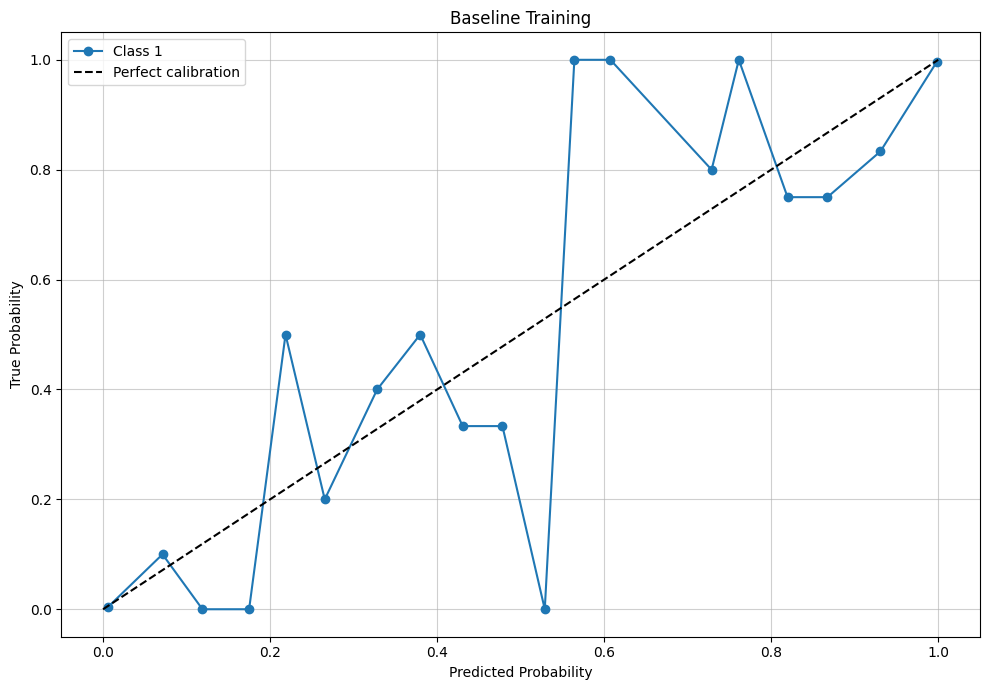

Epoch 77/300, Train Loss: 0.0133, Validation Loss: 0.0556, Learning Rate: 1.0000000000000004e-08
Epoch 78/300, Train Loss: 0.0134, Validation Loss: 0.0576, Learning Rate: 1.0000000000000004e-08
Epoch 79/300, Train Loss: 0.0115, Validation Loss: 0.0570, Learning Rate: 1.0000000000000004e-08
Epoch 80/300, Train Loss: 0.0120, Validation Loss: 0.0563, Learning Rate: 1.0000000000000004e-08
Epoch 81/300, Train Loss: 0.0121, Validation Loss: 0.0582, Learning Rate: 1.0000000000000004e-08


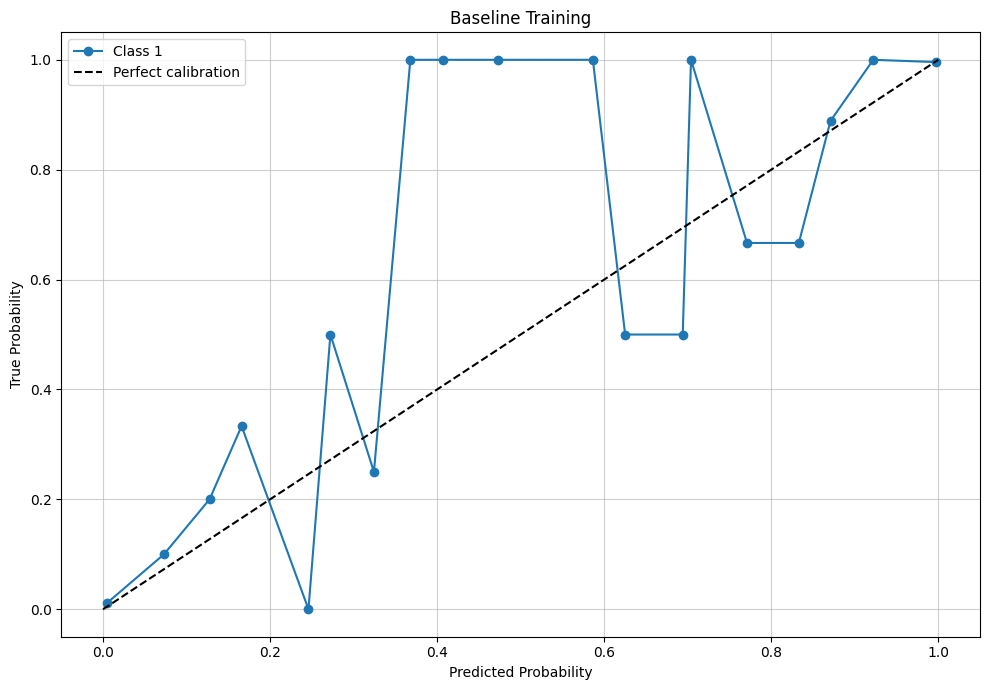

Epoch 82/300, Train Loss: 0.0102, Validation Loss: 0.0567, Learning Rate: 1.0000000000000004e-08
Epoch 83/300, Train Loss: 0.0106, Validation Loss: 0.0564, Learning Rate: 1.0000000000000004e-08
Epoch 84/300, Train Loss: 0.0112, Validation Loss: 0.0584, Learning Rate: 1.0000000000000004e-08
Epoch 85/300, Train Loss: 0.0102, Validation Loss: 0.0562, Learning Rate: 1.0000000000000004e-08
Epoch 86/300, Train Loss: 0.0116, Validation Loss: 0.0560, Learning Rate: 1.0000000000000004e-08


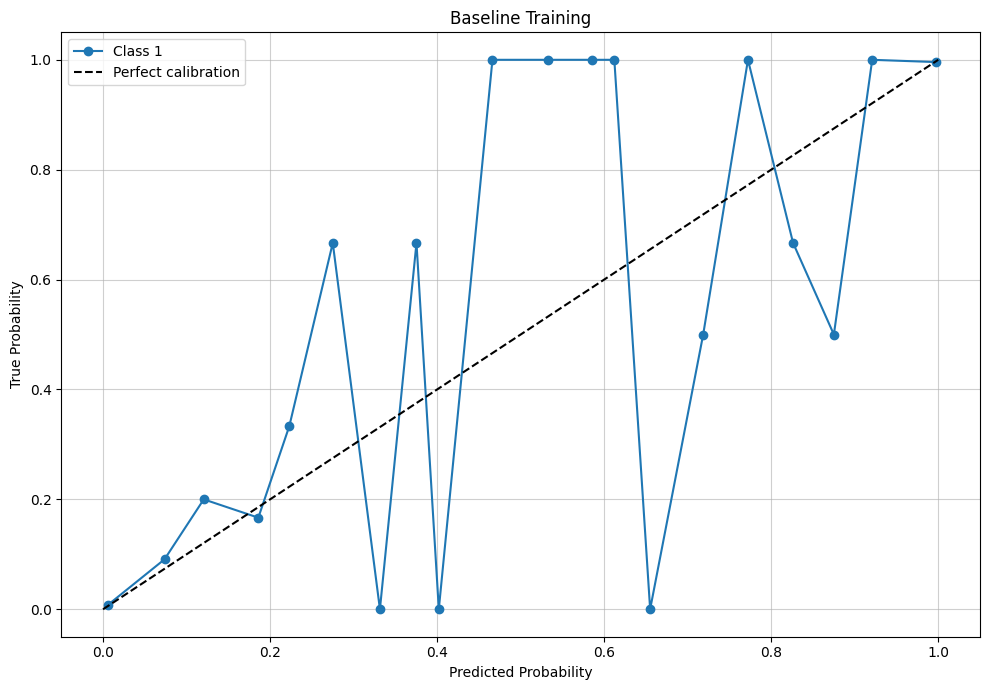

Epoch 87/300, Train Loss: 0.0124, Validation Loss: 0.0576, Learning Rate: 1.0000000000000004e-08
Epoch 88/300, Train Loss: 0.0096, Validation Loss: 0.0562, Learning Rate: 1.0000000000000004e-08
Epoch 89/300, Train Loss: 0.0124, Validation Loss: 0.0612, Learning Rate: 1.0000000000000004e-08
Epoch 90/300, Train Loss: 0.0134, Validation Loss: 0.0563, Learning Rate: 1.0000000000000004e-08
Epoch 91/300, Train Loss: 0.0098, Validation Loss: 0.0559, Learning Rate: 1.0000000000000004e-08


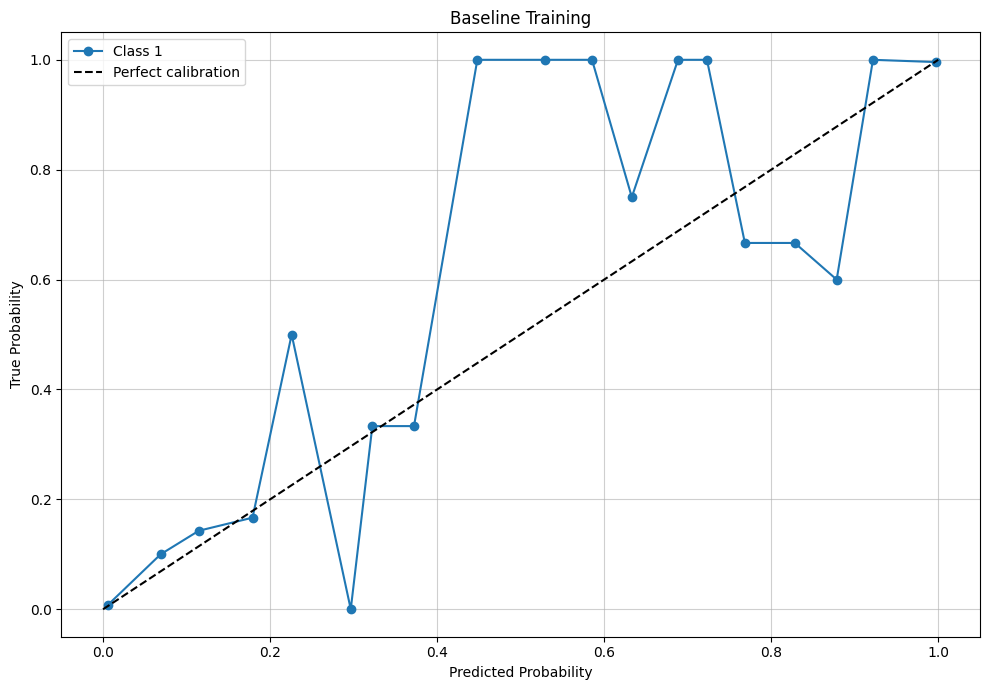

Epoch 92/300, Train Loss: 0.0115, Validation Loss: 0.0597, Learning Rate: 1.0000000000000004e-08
Early stopping triggered after 92 epochs.


In [12]:
train_losses, val_losses = model.train_model(epochs)

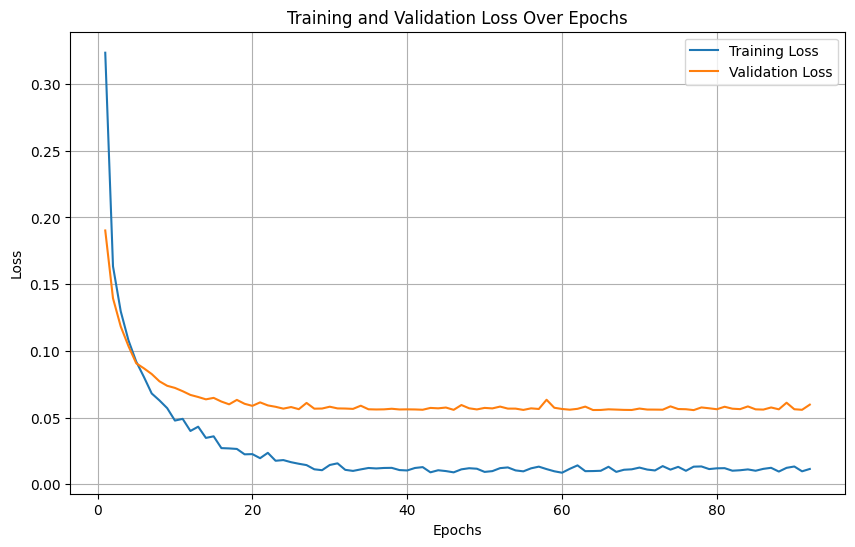

In [13]:
plot_loss(train_losses, val_losses)

In [14]:
true_labels, predicted_labels_baseline, confidence_baseline, _, logits_baseline = model.evaluate()
model.optimize_platt_scaling()
model.optimize_temperature()
model.optimize_histogram_binning()

In [15]:
predicted_labels_platt_scaling, confidence_platt_scaling = model.evaluate_with_platt_scaling(logits_baseline)

predicted_labels_temperature_scaling, confidence_temperature_scaling = model.evaluate_with_temperature_scaling(logits_baseline)

predicted_labels_histogram_binning, confidence_histogram_binning= model.evaluate_with_histogram_binning(confidence_baseline)


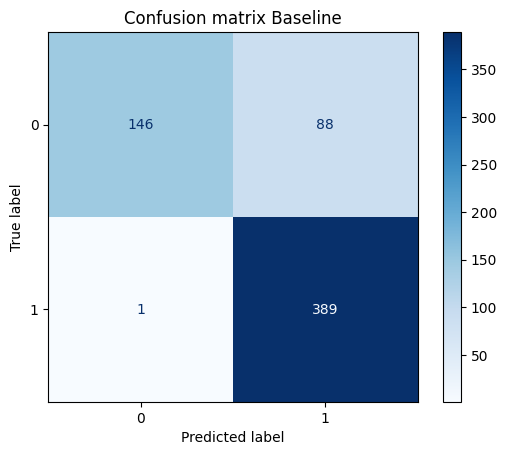

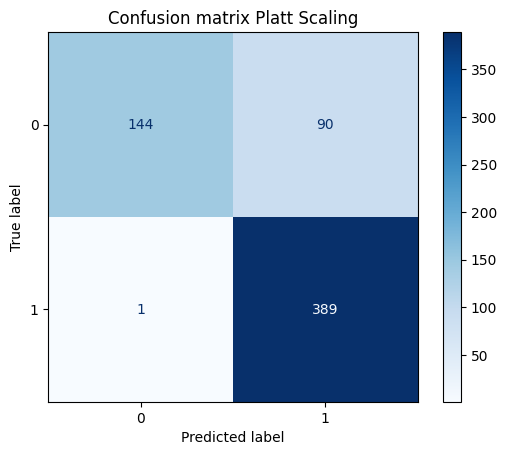

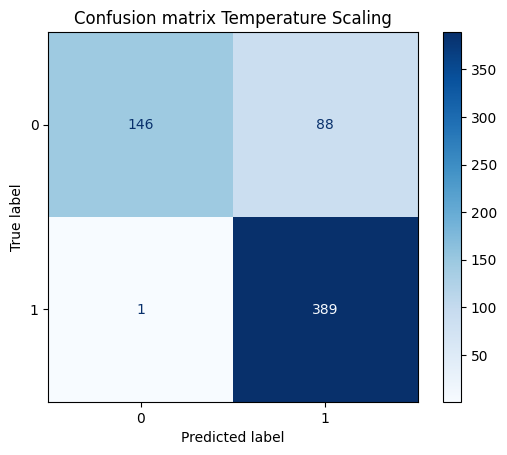

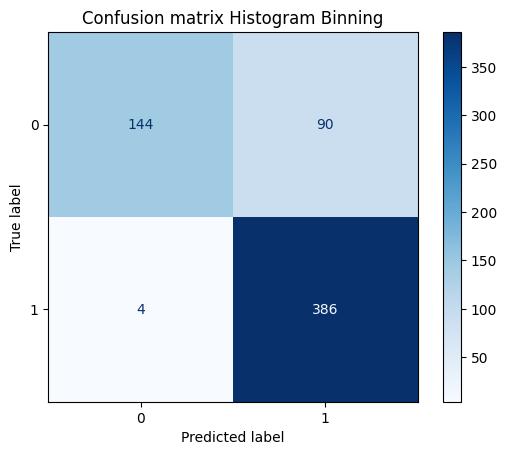

In [16]:
plot_confusion_matrix(true_labels=true_labels,
                      predicted_labels=predicted_labels_baseline,
                      title="Confusion matrix Baseline")

plot_confusion_matrix(true_labels=true_labels,
                      predicted_labels=predicted_labels_platt_scaling,
                      title="Confusion matrix Platt Scaling")

plot_confusion_matrix(true_labels=true_labels,
                      predicted_labels=predicted_labels_temperature_scaling,
                      title="Confusion matrix Temperature Scaling")

plot_confusion_matrix(true_labels=true_labels,
                      predicted_labels=predicted_labels_histogram_binning,
                      title="Confusion matrix Histogram Binning")

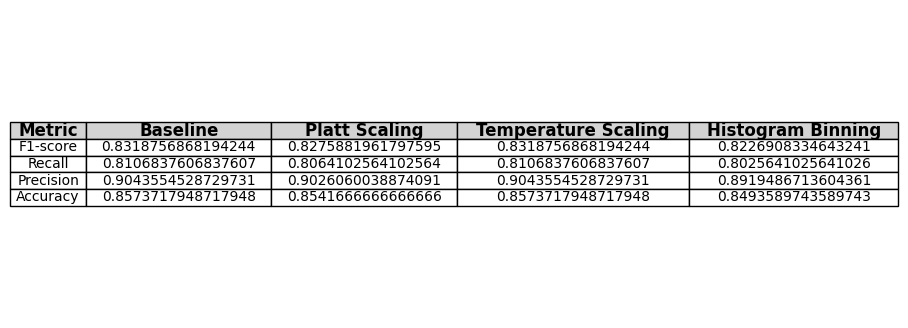

In [17]:
results = {
    "Metric": ["F1-score", "Recall", "Precision", "Accuracy"],
    "Baseline": [
        f1_score(true_labels, predicted_labels_baseline, average='macro', zero_division=0),
        recall_score(true_labels, predicted_labels_baseline, average='macro', zero_division=0),
        precision_score(true_labels, predicted_labels_baseline, average='macro', zero_division=0),
        accuracy_score(true_labels, predicted_labels_baseline),
    ],
    "Platt Scaling": [
        f1_score(true_labels, predicted_labels_platt_scaling, average='macro', zero_division=0),
        recall_score(true_labels, predicted_labels_platt_scaling, average='macro', zero_division=0),
        precision_score(true_labels, predicted_labels_platt_scaling, average='macro', zero_division=0),
        accuracy_score(true_labels, predicted_labels_platt_scaling),
    ],
    "Temperature Scaling": [
        f1_score(true_labels, predicted_labels_temperature_scaling, average='macro',
                 zero_division=0),
        recall_score(true_labels, predicted_labels_temperature_scaling, average='macro',
                     zero_division=0),
        precision_score(true_labels, predicted_labels_temperature_scaling, average='macro',
                        zero_division=0),
        accuracy_score(true_labels, predicted_labels_temperature_scaling),
    ],
    "Histogram Binning": [
        f1_score(true_labels, predicted_labels_histogram_binning, average='macro',
                 zero_division=0),
        recall_score(true_labels, predicted_labels_histogram_binning, average='macro',
                     zero_division=0),
        precision_score(true_labels, predicted_labels_histogram_binning, average='macro',
                        zero_division=0),
        accuracy_score(true_labels, predicted_labels_histogram_binning),
    ],
}

plot_metrics_table(results)

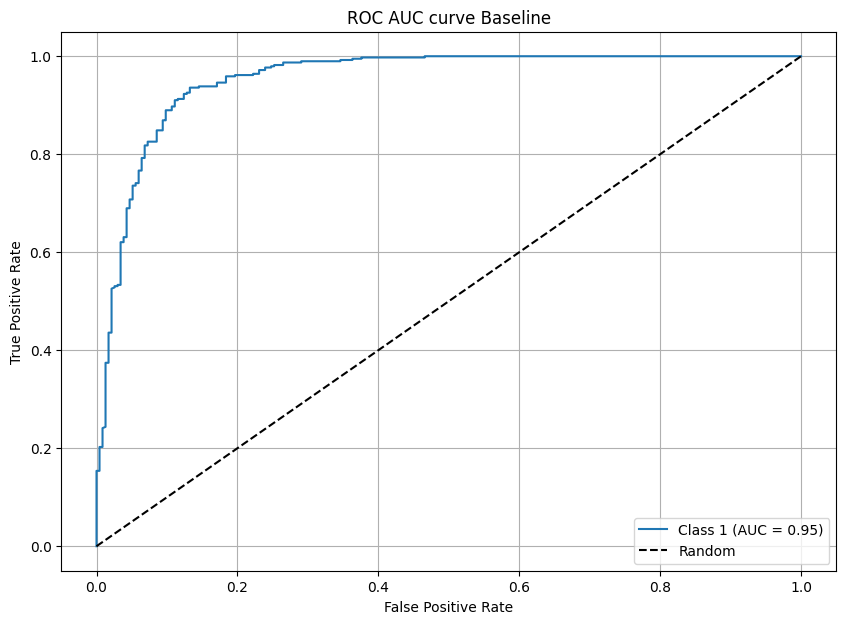

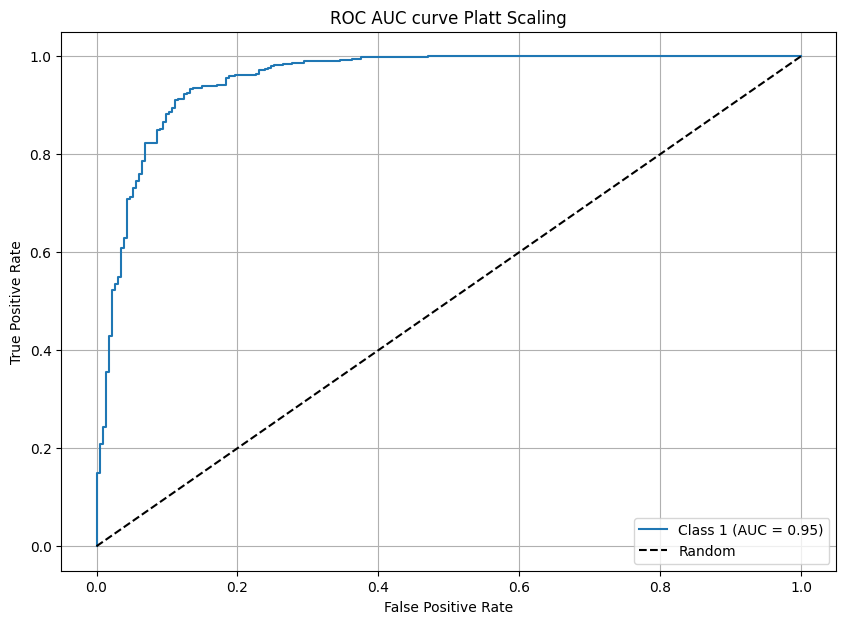

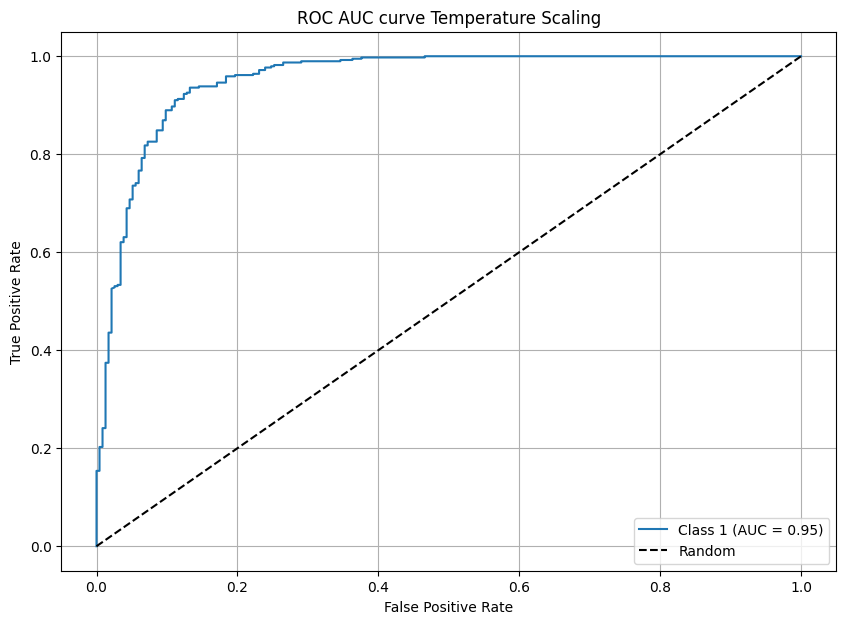

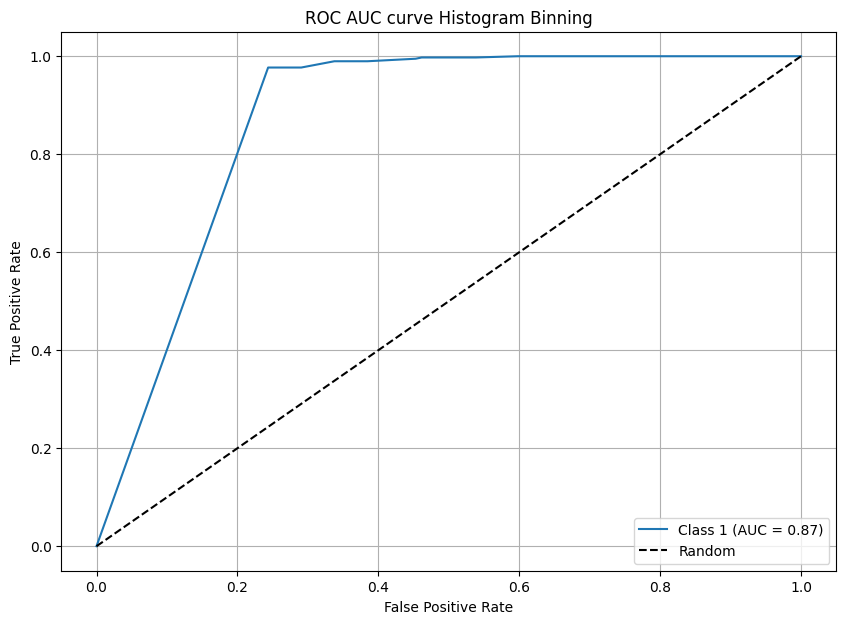

In [18]:
plot_multiclass_roc_auc(y_true=true_labels,
                        y_pred_proba=confidence_baseline,
                        title="ROC AUC curve Baseline")

plot_multiclass_roc_auc(y_true=true_labels,
                        y_pred_proba=confidence_platt_scaling,
                        title="ROC AUC curve Platt Scaling")

plot_multiclass_roc_auc(y_true=true_labels,
                        y_pred_proba=confidence_temperature_scaling,
                        title="ROC AUC curve Temperature Scaling")

plot_multiclass_roc_auc(y_true=true_labels,
                        y_pred_proba=confidence_histogram_binning,
                        title="ROC AUC curve Histogram Binning")

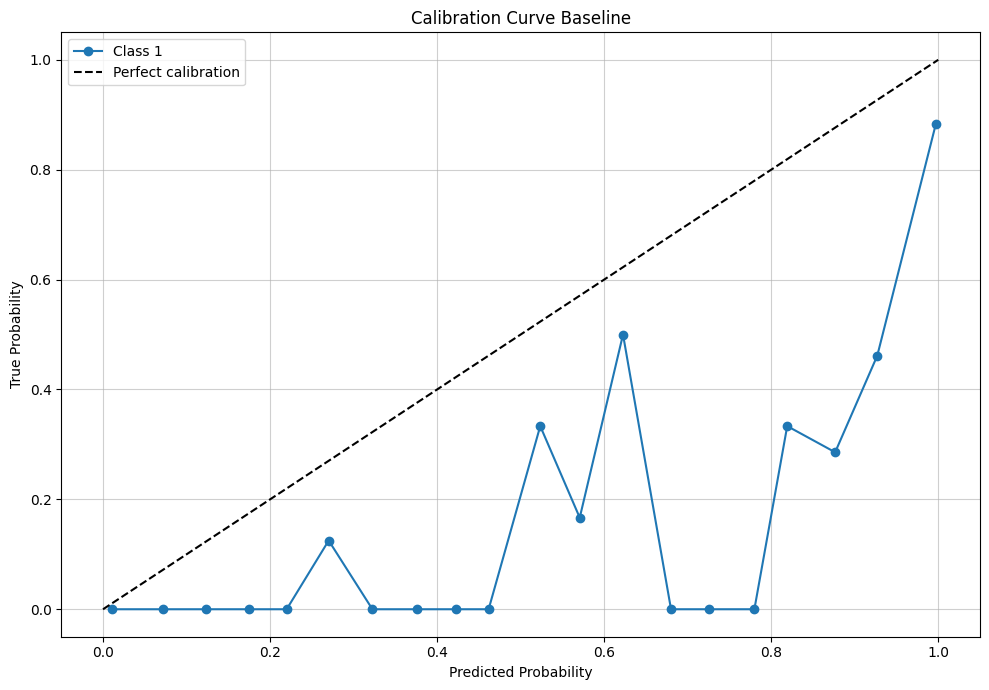

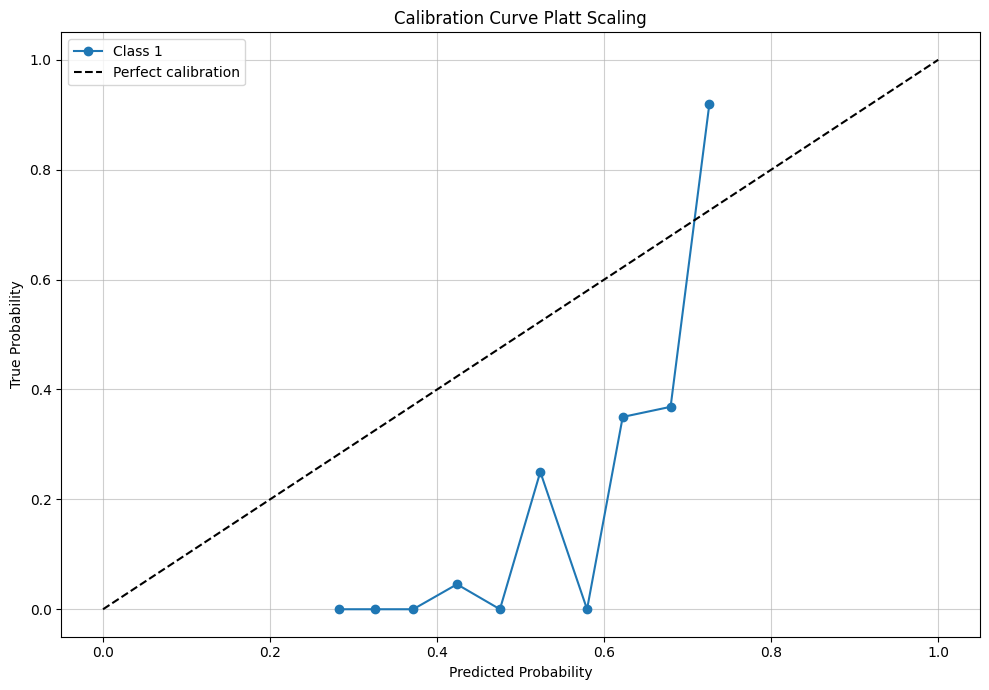

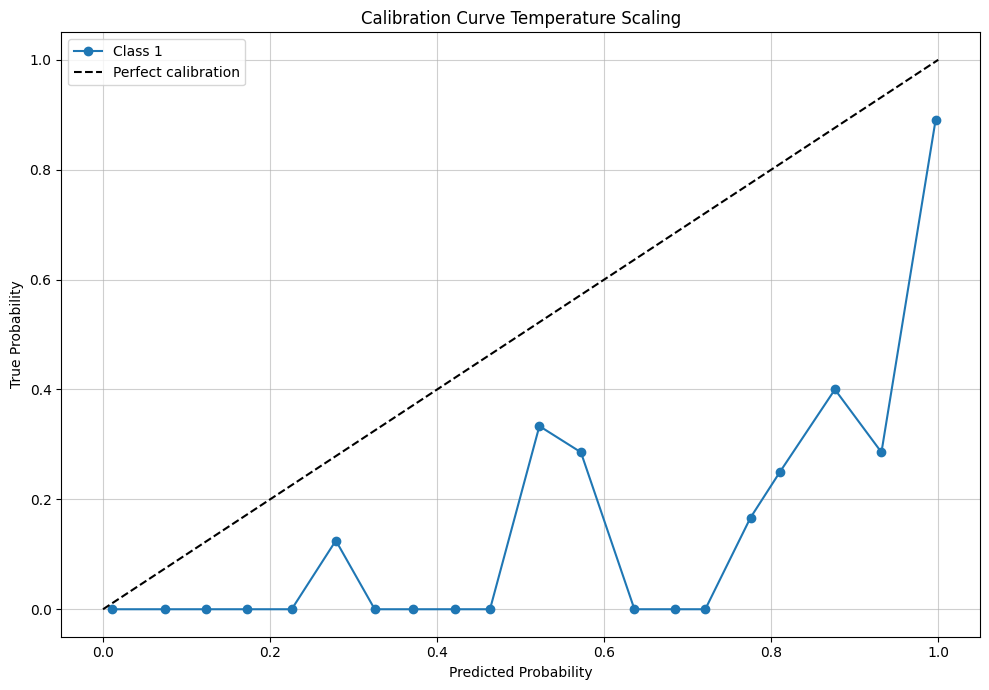

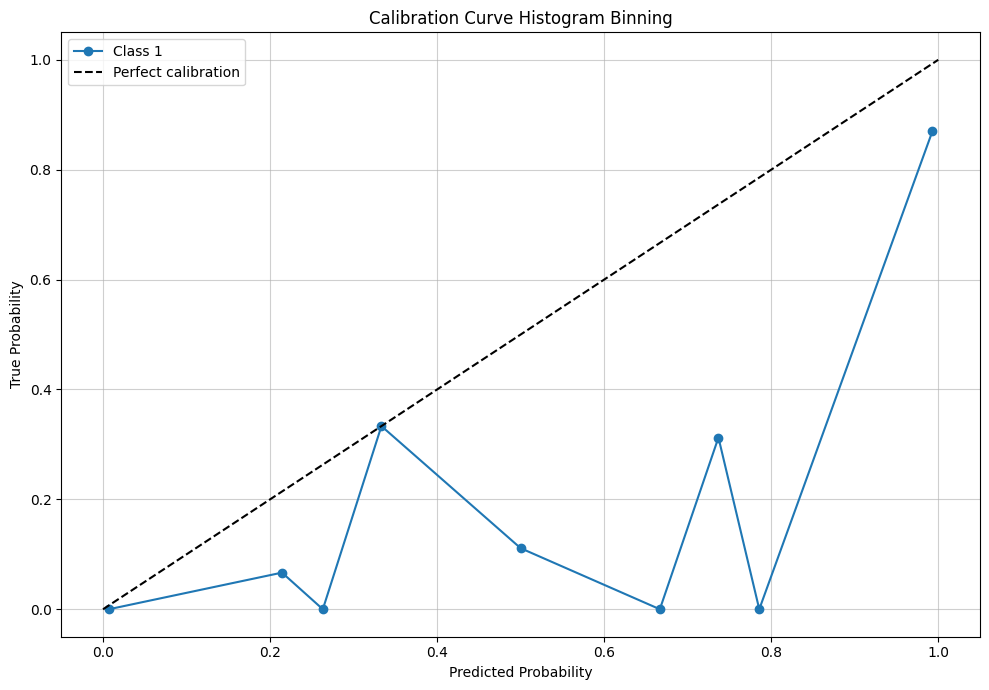

In [19]:
plot_multiclass_calibration_curve(true_labels, confidence_baseline,
                                  title="Calibration Curve Baseline")

plot_multiclass_calibration_curve(true_labels, confidence_platt_scaling,
                                  title="Calibration Curve Platt Scaling")

plot_multiclass_calibration_curve(true_labels, confidence_temperature_scaling,
                                  title="Calibration Curve Temperature Scaling")

plot_multiclass_calibration_curve(true_labels, confidence_histogram_binning,
                                  title="Calibration Curve Histogram Binning")

In [10]:
import torch

torch.save(model.model.state_dict(), "model.pth")

In [12]:
model.load_existing_model("model.pth")

KeyboardInterrupt: 